# Widget example

In [1]:
!env | grep -q 'colab' && pip install finesse || echo 'Not on google colab, assuming finesse already installed'

Not on google colab, assuming finesse already installed


In [2]:
!env | grep -q 'colab' && pip install ipympl 
try:
    from google.colab import output
    output.enable_custom_widget_manager()
except ModuleNotFoundError as err:
    # Error handling
    print("Google module not found")
%matplotlib ipympl

Google module not found


## loading file

In [3]:
# %load ccd_viewer.py
"""
CCD Viewer Widget Module

Interactive matplotlib widget for viewing and analyzing a cavity scane
generated by Finesse with a CCD detector and scanning a mirror position.
Andreas Freise, 11.01.2026

Features:
- beam profile as 2D image or 3D surface plot
- (optional) horizontal and vertical line profiles
- Auto-scaling per frame or global scaling
- colormap selector 
- lin/log scale selector
- Dark mode support (works in VScode)
- Optimized for fast updates using persistent plot objects

Example:
    >>> from ccd_viewer import create_unified_viewer, create_widget_controls, display_viewer
    >>> view_func, fig = create_unified_viewer(data, extent, zmin, zmax)
    >>> controls = create_widget_controls(ccd_data)
    >>> display_viewer(view_func, controls)

Requires:
- ipympl to enable the '%matplotlib widget' command     
"""

__version__ = '1.0.0'

import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import (IntSlider, FloatSlider, Dropdown, VBox, HBox, 
                        Play, jslink, Checkbox, interactive_output, Layout)
from IPython.display import display, HTML


# Dark mode color constants
DARK_BG_COLOR = '#2a2a2a'
DARK_FIG_BG_COLOR = '#2e2e2e'
LIGHT_BG_COLOR = 'white'


def _format_axis_scientific(axis, max_ticks=None, set_scientific=True):
    """
    Helper function to format axis with scientific notation and optional tick limiting.
    
    Parameters
    ----------
    axis : matplotlib.axis.Axis
        The axis to format
    max_ticks : int, optional
        Maximum number of ticks. If None, don't limit ticks.
    """
    if set_scientific:
        axis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f'{x:.2e}'))
    if max_ticks is not None:
        axis.set_major_locator(plt.MaxNLocator(max_ticks))


def apply_dark_mode_css():
    """
    Apply dark mode CSS styling to ipywidgets.
    Call this function in your notebook to enable dark widget styling.
    Works in Jupyter and VSCode.
    """
    dark_css = """
    <style>
    /* Dark mode for ipywidgets - comprehensive styling */
    
    /* VSCode output cell background */
    .cell-output-ipywidget-background {
        background-color: transparent !important;
    }
    
    .output {
        background-color: transparent !important;
    }
    
    /* Widget container backgrounds */
    .widget-hbox, .widget-vbox, .jupyter-widgets, .widget-box {
        background-color: transparent !important;
    }
    
    /* All widget labels */
    .widget-label, .widget-label-basic {
        color: #e0e0e0 !important;
        background-color: transparent !important;
    }
    
    /* Sliders */
    .widget-slider .ui-slider {
        background: #4a4a4a !important;
    }
    
    .widget-slider .ui-slider .ui-slider-handle {
        background: #2196F3 !important;
        border: 2px solid #1976D2 !important;
    }
    
    .widget-slider .ui-slider .ui-slider-range {
        background: #1976D2 !important;
    }
    
    .widget-readout {
        color: #e0e0e0 !important;
        background-color: #2a2a2a !important;
    }
    
    /* Dropdowns */
    .widget-dropdown select,
    .widget-select select {
        background-color: #3a3a3a !important;
        color: #e0e0e0 !important;
        border: 1px solid #5a5a5a !important;
    }
    
    .widget-dropdown select option {
        background-color: #3a3a3a !important;
        color: #e0e0e0 !important;
    }
    
    /* Text inputs */
    .widget-text input,
    .widget-textarea textarea {
        background-color: #3a3a3a !important;
        color: #e0e0e0 !important;
        border: 1px solid #5a5a5a !important;
    }
    
    /* Checkboxes - style the container */
    .widget-checkbox {
        color: #e0e0e0 !important;
    }
    
    .widget-checkbox label {
        color: #e0e0e0 !important;
    }
    
    .widget-checkbox input[type="checkbox"] {
        accent-color: #2196F3;
        filter: brightness(1.2);
    }
    
    /* Buttons */
    .widget-button, .widget-toggle-button {
        background-color: #4a4a4a !important;
        color: #e0e0e0 !important;
        border: 1px solid #5a5a5a !important;
    }
    
    .widget-button:hover, .widget-toggle-button:hover {
        background-color: #5a5a5a !important;
    }
    
    /* Play button */
    .widget-play {
        filter: brightness(1.2) invert(0.85);
    }
    
    /* Matplotlib 3D navigation toolbar buttons */
    .matplotlib-toolbar button,
    .matplotlib-toolbar-button {
        background-color: #4a4a4a !important;
        color: #e0e0e0 !important;
        border: 1px solid #5a5a5a !important;
        filter: invert(0.85) hue-rotate(180deg);
    }
    
    .matplotlib-toolbar {
        background-color: #2a2a2a !important;
    }
    
    /* Output widgets */
    .jupyter-widgets-output-area {
        background-color: transparent !important;
    }
    
    /* Description (label) elements */
    .widget-inline-hbox .widget-label,
    .widget-inline-vbox .widget-label {
        color: #e0e0e0 !important;
    }
    
    /* Additional widget types */
    .widget-html {
        color: #e0e0e0 !important;
    }
    
    /* Widget descriptions */
    div.widget-subarea {
        color: #e0e0e0 !important;
        background-color: transparent !important;
    }
    </style>
    """
    display(HTML(dark_css))


def create_unified_viewer(data, extent, zmin, zmax, figsize=(14, 6), max_ticks=5, dark_mode=False):
    """
    Creates a viewer for the beam profile.
    
    Parameters
    ----------
    data : ndarray
        3D array of CCD images (frames, height, width), 
        typically the output of a Finesse cavity scan
    extent : tuple
        Spatial extent (xmin, xmax, ymin, ymax) in meters
    zmin, zmax : float
        Global min/max intensity values for color scaling
    figsize : tuple, optional
        Figure size (width, height) in inches. Default (14, 6)
    max_ticks : int, optional
        Maximum number of ticks on profile plot axes. Default 5
        Adjust this if axis labels overlap (fewer ticks = less overlap)
    dark_mode : bool, optional
        If True, use dark background theme. Default False
    
    Returns
    -------
    view : function
        View function to be used with interactive widgets
    fig : matplotlib.figure.Figure
        The figure object
    """
    # Apply dark mode style if requested
    if dark_mode:
        plt.style.use('dark_background')
    else:
        # Reset to default style
        plt.style.use('default')
    
    # Precompute coordinate arrays (constant across all frames)
    ny, nx = data.shape[1], data.shape[2]
    x_coords = np.linspace(extent[0], extent[1], nx)
    y_coords = np.linspace(extent[2], extent[3], ny)
    
    # Create figure with flexible layout
    fig = plt.figure(figsize=figsize)
    fig.canvas.header_visible = False  # Hide the 'Figure 1' header
    
    # Set figure background color for dark mode
    if dark_mode:
        fig.patch.set_facecolor(DARK_FIG_BG_COLOR)
    
    # Dictionary of shared variables 
    state = {
        'cb': None,
        'im': None,
        'surf': None,  # For 3D surface plot
        'hline': None,
        'vline': None,
        'hprofile_line': None,
        'vprofile_line': None,
        'gs': None,
        'ax_img': None,
        'ax_hprofile': None,
        'ax_vprofile': None,
        'current_mode': None,
        'current_3d': None,
        'dark_mode': dark_mode,  # Store dark mode setting
    }
    
    def setup_layout(show_profiles, show_3d):
        """Setup or reconfigure the figure layout based on profile display mode and 3D mode."""
        # Clear figure if layout needs to change
        mode_key = (show_profiles, show_3d)
        if state['current_mode'] != mode_key:
            fig.clear()
            state['cb'] = None
            state['im'] = None
            state['surf'] = None
            state['hline'] = None
            state['vline'] = None
            state['hprofile_line'] = None
            state['vprofile_line'] = None
            
            if show_profiles:
                # Layout with profiles - use gridspec with proper margins
                state['gs'] = fig.add_gridspec(2, 2, width_ratios=[2, 1], height_ratios=[1, 1],
                                               left=0.10, right=0.88, bottom=0.10, top=0.90,
                                               hspace=0.40, wspace=0.40)
                if show_3d:
                    state['ax_img'] = fig.add_subplot(state['gs'][:, 0], projection='3d')
                else:
                    state['ax_img'] = fig.add_subplot(state['gs'][:, 0])
                state['ax_hprofile'] = fig.add_subplot(state['gs'][0, 1])
                state['ax_vprofile'] = fig.add_subplot(state['gs'][1, 1])
            else:
                # Simple layout without profiles - strongly left-justified
                if show_3d:
                    # Left-aligned 3D plot 
                    state['ax_img'] = fig.add_axes([0.08, 0.10, 0.65, 0.80], projection='3d')
                else:
                    # Left-aligned 2D plot
                    state['ax_img'] = fig.add_axes([0.08, 0.10, 0.65, 0.80])
                state['ax_hprofile'] = None
                state['ax_vprofile'] = None
            
            state['current_mode'] = mode_key
            state['current_3d'] = show_3d
    
    def view(frame, cmap, autoscale, show_crosshairs, show_stats, 
             vmax_scale, log_scale, show_profiles, show_3d, profile_row, profile_col):
        """
        Unified view function with all control options.
        """
        # Setup layout if needed
        setup_layout(show_profiles, show_3d)
        
        # Calculate color limits
        if autoscale:
            current_frame = data[frame]
            data_min = 0.0  # Always start from 0 to prevent label jumping
            data_max = np.nanmax(current_frame)
        else:
            data_min = zmin
            data_max = zmax
        
        # Apply user scaling (vmin fixed at 1.0, only vmax adjustable)
        vmin = data_min * 1.0
        vmax = data_max * vmax_scale
        
        # Log scale if requested
        plot_data = data.copy()
        if log_scale:
            # Add small offset to avoid log(0)
            offset = np.nanmin(data[data > 0]) * 0.01 if np.any(data > 0) else 1e-20
            plot_data = np.log10(plot_data + offset)
            vmin = np.log10(vmin + offset)
            vmax = np.log10(vmax + offset)
        
        I = plot_data[frame]
        
        # Branch based on 2D vs 3D mode
        if show_3d:
            # 3D Surface Plot
            # Create mesh grid
            X, Y = np.meshgrid(x_coords, y_coords)
            
            if state['surf'] is None:
                # First time: create 3D surface
                state['surf'] = state['ax_img'].plot_surface(X, Y, I, cmap=cmap,
                                                             vmin=vmin, vmax=vmax,
                                                             linewidth=0, antialiased=True,
                                                             alpha=0.9)
                state['ax_img'].set_xlabel('x [m]')
                state['ax_img'].set_ylabel('y [m]')
                # Only set z-label if not in profile mode (profiles already have 'Intensity' labels)
                if not show_profiles:
                    state['ax_img'].set_zlabel('Intensity')
                state['ax_img'].set_zlim([vmin, vmax])
                # Remove z-axis tick labels to prevent jitter
                state['ax_img'].zaxis.set_ticklabels([])
            else:
                # Update: remove old surface and create new one
                # (matplotlib doesn't support updating surface data directly)
                state['surf'].remove()
                state['surf'] = state['ax_img'].plot_surface(X, Y, I, cmap=cmap,
                                                             vmin=vmin, vmax=vmax,
                                                             linewidth=0, antialiased=True,
                                                             alpha=0.9)
                state['ax_img'].set_zlim([vmin, vmax])
            
            # Update title
            state['ax_img'].set_title(f"CCD in transmission of the cavity (Frame {frame}/{data.shape[0]-1})")
                        
        else:
            # 2D Image Plot
            # Initialize or update image
            if state['im'] is None:
                state['im'] = state['ax_img'].imshow(I, origin='lower', aspect='equal',
                                                     cmap=cmap, vmin=vmin, vmax=vmax,
                                                     extent=extent)
                state['ax_img'].set_xlabel('x [m]')
                state['ax_img'].set_ylabel('y [m]')
                # Force axis to stay in its allocated space
                state['ax_img'].set_adjustable('box')
                state['ax_img'].set_anchor('W')  # Anchor to West (left)
            else:
                state['im'].set_data(I)
                state['im'].set_cmap(cmap)
                state['im'].set_clim(vmin, vmax)
            
            # Update title
            state['ax_img'].set_title(f"CCD in transmission of the cavity (Frame {frame}/{data.shape[0]-1})")
            
            # Handle crosshairs (only in 2D mode)
            # When profiles are shown, crosshairs indicate profile positions
            
            if show_crosshairs:
                if state['hline'] is None:
                    state['hline'] = state['ax_img'].axhline(y_coords[profile_row], 
                                                             color='cyan', linestyle='--', 
                                                             alpha=0.7, linewidth=1.5)
                    state['vline'] = state['ax_img'].axvline(x_coords[profile_col], 
                                                             color='yellow', linestyle='--', 
                                                             alpha=0.7, linewidth=1.5)
                else:
                    state['hline'].set_ydata([y_coords[profile_row], y_coords[profile_row]])
                    state['vline'].set_xdata([x_coords[profile_col], x_coords[profile_col]])
                    state['hline'].set_visible(True)
                    state['vline'].set_visible(True)
            else:
                if state['hline'] is not None:
                    state['hline'].set_visible(False)
                    state['vline'].set_visible(False)
            
            # Handle statistics overlay (only in 2D mode)
            # Remove old text annotations
            for txt in state['ax_img'].texts:
                txt.remove()
            
            if show_stats:
                # Set background color based on dark mode
                stats_bg_color = DARK_BG_COLOR if state['dark_mode'] else LIGHT_BG_COLOR
                stats_alpha = 0.9 if state['dark_mode'] else 0.7
                
                stats_text = f"Min: {np.nanmin(I):.2e}\nMax: {np.nanmax(I):.2e}\nMean: {np.nanmean(I):.2e}"
                state['ax_img'].text(0.02, 0.98, stats_text, transform=state['ax_img'].transAxes,
                                    verticalalignment='top', 
                                    bbox=dict(boxstyle='round', facecolor=stats_bg_color, alpha=stats_alpha),
                                    fontsize=8, family='monospace')
        
        # Handle profiles
        if show_profiles:
            if state['hprofile_line'] is None:
                # Initialize profiles
                state['hprofile_line'], = state['ax_hprofile'].plot(x_coords, I[profile_row, :],
                                                                    'c-', linewidth=2)
                state['ax_hprofile'].set_xlabel('x [m]')
                state['ax_hprofile'].set_ylabel('Intensity')
                state['ax_hprofile'].grid(True, alpha=0.3)
                state['ax_hprofile'].set_ylim([vmin, vmax])
                # Move y-axis to the right side
                state['ax_hprofile'].yaxis.tick_right()
                state['ax_hprofile'].yaxis.set_label_position('right')
                # Format axes with scientific notation and tick limiting
                _format_axis_scientific(state['ax_hprofile'].xaxis, max_ticks, False)
                _format_axis_scientific(state['ax_hprofile'].yaxis)
                
                state['vprofile_line'], = state['ax_vprofile'].plot(y_coords, I[:, profile_col],
                                                                    'y-', linewidth=2)
                state['ax_vprofile'].set_xlabel('y [m]')
                state['ax_vprofile'].set_ylabel('Intensity')
                state['ax_vprofile'].grid(True, alpha=0.3)
                state['ax_vprofile'].set_ylim([vmin, vmax])
                # Move y-axis to the right side
                state['ax_vprofile'].yaxis.tick_right()
                state['ax_vprofile'].yaxis.set_label_position('right')
                # Format axes with scientific notation and tick limiting
                _format_axis_scientific(state['ax_vprofile'].xaxis, max_ticks, False)
                _format_axis_scientific(state['ax_vprofile'].yaxis)
            else:
                # Update profiles
                state['hprofile_line'].set_ydata(I[profile_row, :])
                state['vprofile_line'].set_ydata(I[:, profile_col])
                state['ax_hprofile'].set_ylim([vmin, vmax])
                state['ax_vprofile'].set_ylim([vmin, vmax])
            
            # Add titles as text inside plots (to prevent overlap with axes)
            # Clear old text
            for txt in state['ax_hprofile'].texts:
                txt.remove()
            for txt in state['ax_vprofile'].texts:
                txt.remove()
            
            # Set background color based on dark mode
            box_facecolor = DARK_BG_COLOR if state['dark_mode'] else LIGHT_BG_COLOR
            box_alpha = 0.9 if state['dark_mode'] else 0.8
            
            # Add new text labels
            state['ax_hprofile'].text(0.98, 0.95, f'H-Profile (row {profile_row})',
                                     transform=state['ax_hprofile'].transAxes,
                                     ha='right', va='top',
                                     bbox=dict(boxstyle='round,pad=0.3', facecolor=box_facecolor, alpha=box_alpha),
                                     fontsize=9)
            state['ax_vprofile'].text(0.98, 0.95, f'V-Profile (col {profile_col})',
                                     transform=state['ax_vprofile'].transAxes,
                                     ha='right', va='top',
                                     bbox=dict(boxstyle='round,pad=0.3', facecolor=box_facecolor, alpha=box_alpha),
                                     fontsize=9)

        
        # Update or create colorbar
        # Use appropriate mappable (im for 2D, surf for 3D)
        mappable = state['surf'] if show_3d else state['im']
        
        if state['cb'] is None:
            # Use fraction instead of shrink to match axes height
            state['cb'] = fig.colorbar(mappable, ax=state['ax_img'], pad=0.02, 
                                      fraction=0.046, aspect=20)
            state['cb'].set_label("Intensity" + (" (log10)" if log_scale else ""))
            state['cb'].formatter.set_powerlimits((-2, 2))
            state['cb'].formatter.set_useMathText(True)
            _format_axis_scientific(state['cb'].ax.yaxis)
        else:
            state['cb'].update_normal(mappable)
            state['cb'].set_label("Intensity" + (" (log10)" if log_scale else ""))
            _format_axis_scientific(state['cb'].ax.yaxis)
        
        fig.canvas.draw_idle()
    
    return view, fig


def create_widget_controls(data):
    """
    Create all the interactive widget controls for the CCD viewer.
    
    Parameters
    ----------
    data : ndarray
        3D array of CCD images (frames, height, width)
    
    Returns
    -------
    dict
        Dictionary containing all widget controls
    """
    controls = {}
    
    # Frame navigation
    controls['frame_slider'] = IntSlider(
        min=0, max=data.shape[0]-1, step=1, value=0,
        description='Frame:',
        continuous_update=True,
        layout=Layout(width='600px')
    )
    
    controls['play'] = Play(
        min=0, max=data.shape[0]-1, step=1, value=0,
        interval=100,
        description="Press play",
        disabled=False
    )
    
    # Link play widget to slider
    jslink((controls['play'], 'value'), (controls['frame_slider'], 'value'))
    
    # Display options
    controls['cmap_dropdown'] = Dropdown(
        options=['inferno', 'viridis', 'plasma', 'magma', 'cividis',
                 'hot', 'coolwarm', 'twilight', 'turbo', 'jet'],
        value='inferno',
        description='Colormap:'
    )
    
    controls['autoscale_check'] = Checkbox(
        value=False,
        description='Auto-scale per frame',
        indent=False
    )
    
    controls['crosshairs_check'] = Checkbox(
        value=False,
        description='Show crosshairs',
        indent=False
    )
    
    controls['stats_check'] = Checkbox(
        value=False,
        description='Show statistics',
        indent=False
    )
    
    controls['log_check'] = Checkbox(
        value=False,
        description='Log scale',
        indent=False
    )
    
    controls['profiles_check'] = Checkbox(
        value=False,
        description='Show line profiles',
        indent=False
    )
    
    controls['view_3d_check'] = Checkbox(
        value=False,
        description='3D surface view',
        indent=False
    )
    
    # Scaling
    controls['vmax_slider'] = FloatSlider(
        min=0.0, max=2.0, step=0.05, value=1.0,
        description='Max scale:',
        continuous_update=True,
        layout=Layout(width='400px')
    )
    
    # Profile position
    controls['row_slider'] = IntSlider(
        min=0, max=data.shape[1]-1, step=1, value=data.shape[1]//2,
        description='Profile Row:',
        continuous_update=True,
        layout=Layout(width='400px')
    )
    
    controls['col_slider'] = IntSlider(
        min=0, max=data.shape[2]-1, step=1, value=data.shape[2]//2,
        description='Profile Col:',
        continuous_update=True,
        layout=Layout(width='400px')
    )
    
    return controls


def display_viewer(view_func, controls):
    """
    Connect the view function to widget controls and display the interactive viewer.
    
    Parameters
    ----------
    view_func : function
        The view function returned by create_unified_viewer
    controls : dict
        Dictionary of widget controls from create_widget_controls
    """
    # Create interactive output
    out = interactive_output(
        view_func,
        {
            'frame': controls['frame_slider'],
            'cmap': controls['cmap_dropdown'],
            'autoscale': controls['autoscale_check'],
            'show_crosshairs': controls['crosshairs_check'],
            'show_stats': controls['stats_check'],
            'vmax_scale': controls['vmax_slider'],
            'log_scale': controls['log_check'],
            'show_profiles': controls['profiles_check'],
            'show_3d': controls['view_3d_check'],
            'profile_row': controls['row_slider'],
            'profile_col': controls['col_slider']
        }
    )
    
    # Layout the widgets - compact two-column arrangement
    # Left column: sliders and dropdown stacked vertically
    left_column = VBox([
        controls['cmap_dropdown'],
        controls['vmax_slider'],
        controls['row_slider'],
        controls['col_slider']
    ])
    
    # Right column: checkboxes in compact grid
    right_column = VBox([
        HBox([controls['autoscale_check'], controls['log_check']]),
        HBox([controls['crosshairs_check'], controls['stats_check']]),
        HBox([controls['profiles_check'], controls['view_3d_check']])
    ], layout=Layout(margin='0px 0px 0px 20px'))  # Add left margin for spacing
    
    # Top row: play and frame slider spanning full width
    top_row = HBox([controls['play'], controls['frame_slider']])
    
    # Middle row: left and right columns side by side
    middle_row = HBox([left_column, right_column])
    
    # Combine all rows
    controls_layout = VBox([top_row, middle_row])
    
    display(controls_layout, out)


# test rest

In [4]:
import finesse 
import matplotlib.pyplot as plt
import numpy as np
finesse.configure(plotting=True)
from finesse.analysis.actions import Xaxis
#from ccd_viewer import create_unified_viewer, create_widget_controls, display_viewer, apply_dark_mode_css

# Enable interactive plots
#%matplotlib widget

In [5]:
L = 3994.485 
rocITM = -1937.9 
rocETM = 2240.0 

cavLIGO = finesse.Model()

cavLIGO.parse(
f"""
# Input optics          
l l1 P=1 #laser with 1W power
s s1 l1.p1 ITM.p1 #space between laser and input test mass

# Input test mass/mirror of the cavity
# T and L are the transmittivity and losses in the mirror
# and R (reflectivity) is computed as R=1-T-L. 
m ITM T=0.0148 L=37.5e-6 Rc={rocITM} #mirror
           
# Space between the two test masses 
s s2 ITM.p2 ETM.p1 L={L} #defined in the geometry

# End test mass 
m ETM T=7.1e-6 L=37.5e-6 Rc={rocETM} #mirror
cav arms source=ETM.p1.o via=ITM.p2.i
""");

In [6]:
## Visualisation of cavity scans for non-Gaussian input beam
## -------------------------------------------------------------------
cav_modes = cavLIGO.deepcopy()
cav_modes.modes(maxtem=4)

# adding HOMs to our input laser beam
cav_modes.l1.tem(0,0,1)
cav_modes.l1.tem(0,1,1)
cav_modes.l1.tem(2,0,1)
cav_modes.l1.tem(3,0,1)
cav_modes.l1.tem(0,4,1)

# adding a camera at tranmission of the cavity
# to visualise the 2D beam shape
cav_modes.parse(
    f"""
    ccd ccd_tra ETM.p2.o xlim=1e-1 ylim=1e-1 npts=100 w0_scaled=false
    """
)

# FSR scans
images = cav_modes.run(Xaxis('ETM.phi', 'lin', 0, 120, 600))
ccd_arr = np.asarray(images["ccd_tra"])
zmin = np.min(ccd_arr)
zmax = np.max(ccd_arr)

Output()

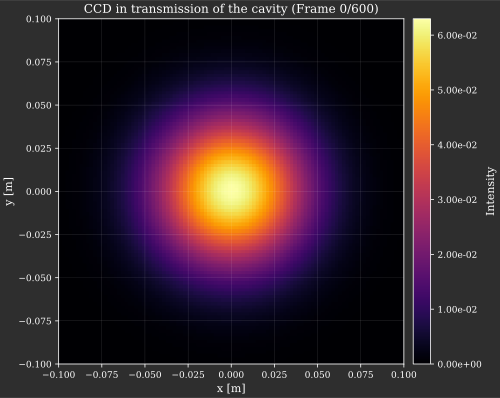

In [7]:
apply_dark_mode_css()  # Apply dark styling to widgets

# Create the viewer with your custom settings
view_func, fig = create_unified_viewer(
    ccd_arr,
    extent=(-1e-1, 1e-1, -1e-1, 1e-1),  # Spatial extent in meters
    zmin=zmin,
    zmax=zmax,
    figsize=(10, 6),  # Customize figure size here
    max_ticks=5,       # Customize tick count here
    dark_mode = True
)

# Create the widget controls
controls = create_widget_controls(ccd_arr)

# Display the interactive viewer
display_viewer(view_func, controls)